In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import multihist as mh
import pandas as pd
import subprocess as subpro
import glob
from tqdm import tqdm
from scipy.interpolate import interp1d
import inference_interface

In [13]:
fname_pattern ="nestresults/toyNEST_{rtype:s}_{emin:.3f}_{emax:.3f}_{n_mc}.csv"
call_name = "./testNEST {n_mc:d} {rtype:s} {emin:.3f} {emax:.3f} -1 -1 &> " + fname_pattern
sbatch_call_name = "sbatch -o "+ fname_pattern +" runpy.sbatch {n_mc:d} {rtype:s} {emin:.3f} {emax:.3f} -1 -1  " 

In [14]:
subpro.call(sbatch_call_name.format(n_mc = 10, rtype="NR", emin = 2, emax=2).split(" "))

0

In [5]:
Emax_ER = 30.
Emax_NR = 80.

Emin = 0.1

nEsteps = 100
n_mc = 100000

ebin_NR = np.logspace(np.log10(Emin), np.log10(Emax_NR), nEsteps+1)
ebin_ER = np.logspace(np.log10(Emin), np.log10(Emax_ER), nEsteps+1)

        f.write(call_name.format(rtype="NR" ,emin=emin, emax=emax, n_mc=n_mc)+"\n")
    
runfile_ER = "runER.sh"

with open(runfile_ER,"w") as f:
    for i in range(nEsteps):
        emin = ebin_ER[i]
        emax = ebin_ER[i+1]
        f.write(call_name.format(rtype="ER" ,emin=emin, emax=emax, n_mc=n_mc)+"\n")

## Submit NRs

In [15]:
for i in range(nEsteps):
    emin = ebin_NR[i]
    emax = ebin_NR[i+1]
    subpro.call(sbatch_call_name.format(n_mc = n_mc, rtype="NR", emin = emin, emax=emax).split(" "))

## Submit ERs 

In [16]:
for i in range(nEsteps):
    emin = ebin_ER[i]
    emax = ebin_ER[i+1]
    subpro.call(sbatch_call_name.format(n_mc = n_mc, rtype="ER", emin = emin, emax=emax).split(" "))

## Collate results in histograms

In [20]:
cs1_bins = np.linspace(0,100,101)
cs2_bins = np.logspace(np.log10(200),np.log10(10000),101)
nrhists = [mh.Histdd(bins=(cs1_bins, cs2_bins)) for i in range(nEsteps)]
erhists = [mh.Histdd(bins=(cs1_bins, cs2_bins)) for i in range(nEsteps)]

In [21]:
for i in tqdm(range(nEsteps)):
    emin = ebin_NR[i]
    emax = ebin_NR[i+1]
    files = glob.glob(fname_pattern.replace("{n_mc}","*").format(rtype="NR",emin=emin,emax=emax))
    #dfs = []
    #for f in files:
    #    d = pd.read_csv(f, sep='[\t|,]', engine='python',names="E_recon field tDrift X Y Z Nph Ne- S1 S1_3Dcor spikeC Ne-extr S2_rawArea S2_3Dcor".split(" "))
    #    dfs.append(d)
    #df = pd.concat(dfs)
    try:
        df = pd.read_csv(files[0], sep='[\t|,]', engine='python',names="E_recon field tDrift X Y Z Nph Ne- S1 S1_3Dcor spikeC Ne-extr S2_rawArea S2_3Dcor".split(" "))
        nrhists[i].add(df.S1_3Dcor, df.S2_3Dcor)
        nrhists[i] /= n_mc
    except:
        pass

100%|██████████| 100/100 [02:22<00:00,  1.43s/it]


In [22]:
for i in tqdm(range(nEsteps)):
    emin = ebin_ER[i]
    emax = ebin_ER[i+1]
    files = glob.glob(fname_pattern.replace("{n_mc}","*").format(rtype="ER",emin=emin,emax=emax))
    dfs = []
    for f in files:
        d = pd.read_csv(f, sep='[\t|,]', engine='python',names="E_recon field tDrift X Y Z Nph Ne- S1 S1_3Dcor spikeC Ne-extr S2_rawArea S2_3Dcor".split(" "))
        dfs.append(d)
    df = pd.concat(dfs)
    erhists[i].add(df.S1_3Dcor, df.S2_3Dcor)
    erhists[i] /= n_mc

100%|██████████| 100/100 [02:23<00:00,  1.44s/it]


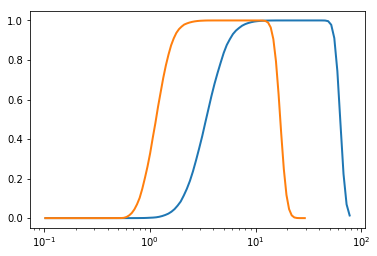

In [27]:
effnr = [h.n for h in nrhists]
ecnr = 0.5*(ebin_NR[0:-1] + ebin_NR[1::])
effer = [h.n for h in erhists]
ecer = 0.5*(ebin_ER[0:-1] + ebin_ER[1::])
plt.clf()
plt.plot(ecnr,effnr)
plt.plot(ecer,effer)
plt.xscale("log")
plt.show()

In [25]:
er_total = mh.Histdd(bins=(ebin_ER, cs1_bins, cs2_bins))
nr_total = mh.Histdd(bins=(ebin_ER, cs1_bins, cs2_bins))
for i,erhist in enumerate(erhists):
    er_total.histogram[i] = erhist.histogram
for i,nrhist in enumerate(nrhists):
    nr_total.histogram[i] = nrhist.histogram

In [26]:
inference_interface.multihist_to_template([er_total, nr_total],"../darwin_proj_run/darwin_likelihood/data/NEST_dummyresponse.hdf5",histogram_names=["er","nr"])